First, we import our libraries.

** Note: there might be an error related to a missing symbol. This can be ignored. **

In [1]:
import torch
import torchvision

/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN3c1017RegisterOperatorsD1Ev)
  Referenced from: '/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torchvision/image.so'
  Expected in: '/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib''If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


We initialise the random number generators for reproducibility. You can later remove these but the results won't be the same accross runs.

In [2]:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

We now define the batch sizes for training and testing.

In [3]:
batch_size_train = 64
batch_size_test = 1000

We now define data loaders which we will later use to obtain data to train/test our model. We also apply a transform to normalise the data (the values 0.1307 and 0.3081 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset.)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./torch-files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./torch-files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

Let's have a look at the structure of our data for 1000 items (`batch_size_test`).

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

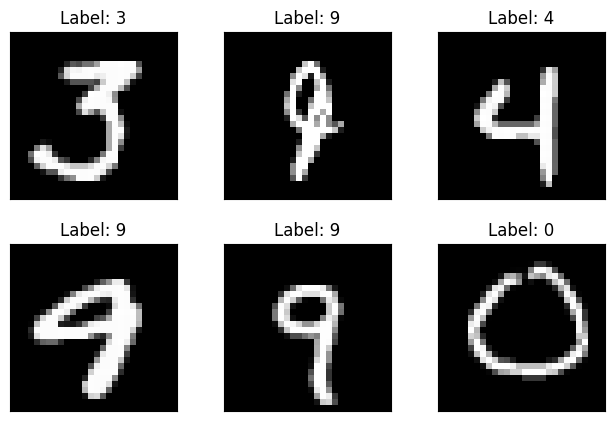

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We use two 2D convolutional layers with a kernel size of 5 (1st: 1 input and 10 outputs; 2nd: 10 inputs and 20 outputs) and two fully-connected layers (1st: 320 inputs and 50 outputs; 2nd: 50 inptus and 10 outputs, the 10 digits). As activation function we'll choose rectified linear units (ReLU) and as a means of regularization we'll use two dropout layers (by default the dropout rate is 50%). Finally, we use a `log_softmax` to obtain a probability estiation for the possbile outcomes.

In PyTorch a nice way to build a network is by creating a new class for the network we wish to build. The `forward` member function is used to compute the output of the network.

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, 1)

We can now instantiate the network and the optimiser: we'll use a stochastic gradient descent with momentum. Our patameters are the learning rate and the momentum.

In [10]:
learning_rate = 0.01
momentum = 0.5

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

We also define a series of arrays to store information about the training, and define the number of epochs we train (here we start with 3) and the logging interval.

In [11]:
n_epochs = 3
log_interval = 10

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

We also define the `train` function, which calls `network.train()` and then proceeds with the necessary updates, and logging (each `log_interval`).

In [12]:
import os
if not os.path.exists("./torch-results"):
  os.mkdir("./torch-results")

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './torch-results/model.pth')
      torch.save(optimizer.state_dict(), './torch-results/optimizer.pth')

We also define a testing function to determine the network's accuracy.

*We use `torch.no_grad()` so that the optimizer does not calculate gradients for the lines of code that follow. This reduces memory usage and speeds up computation.*

In [13]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

Now we can use those helpers to train and test our network. Note that we check the performance of the network before we start to see how it performs (and as expected, it performs poorly because it's untrained and initialised at random).

In [14]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.389709
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.244442
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.498387
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.282343
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.271221
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.198625
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.268675
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.365893
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.447246
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.282100
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.329125
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.456352
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.318430
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.335104
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.256745
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.259587
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.192277
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.485085
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.190825
Train Epoch: 2 [56320/60000 (94%)]	Loss: 0.377582


The network we trained has a 97% accuracy. Not bad.

Let us now plot the performance of our model by checking the training loss (blue line) and test loss (checked at every epoch).

Text(0, 0.5, 'negative log likelihood loss')

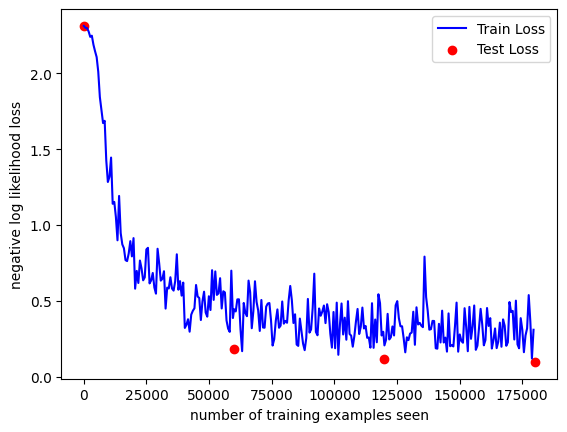

In [15]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

This network could benefit from a bit more training time, but before we continue with training, we can have a look at its performance.

In [16]:
with torch.no_grad():
  output = network(example_data)

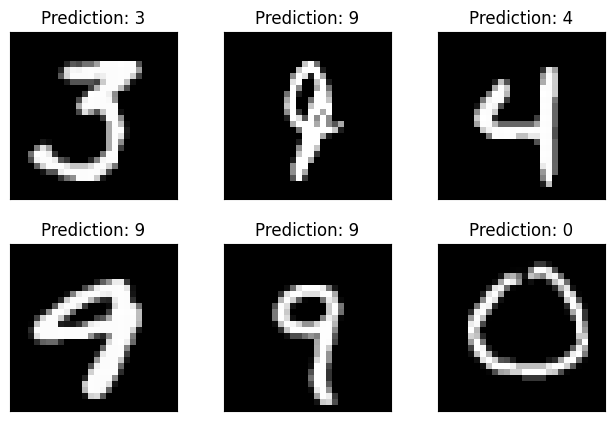

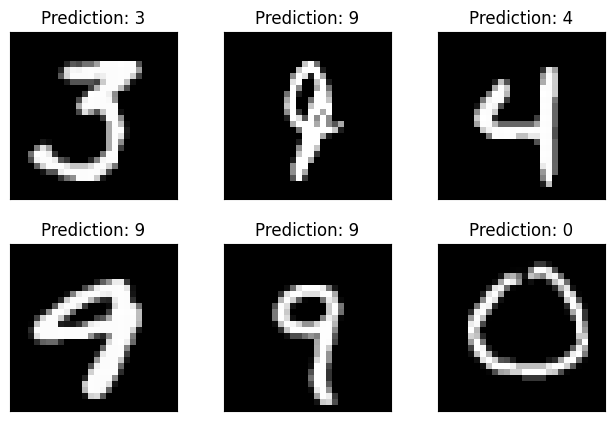

In [17]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

It looks like or network is performing well based on the (limited) examples shown.

Let's check this a bit better using a proper confusion matrix. With it you can get a better idea of how frequent mis-classifications happen (and on which digits).

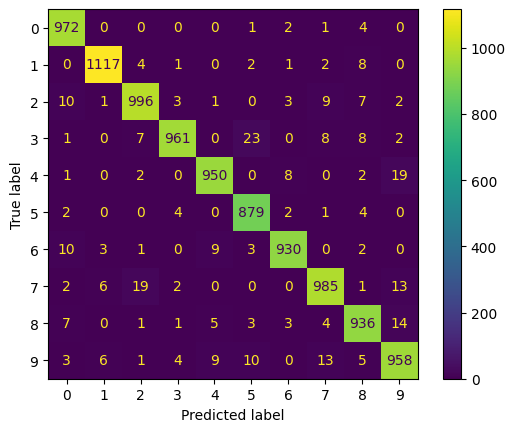

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
with torch.no_grad():
  for data, target in test_loader:
    out = network(data)
    pred = out.data.max(1, keepdim=True)[1]
    y_true.extend(target)
    y_pred.extend(pred)
    
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm).plot()

### Using existing checkpoints to continue training.

It seems that our model could be trained a bit longer. Rather than restarting from scracth, we can re-use existing checkpoints and resume from there.

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [20]:
network_state_dict = torch.load('./torch-results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('./torch-results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [21]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.352964
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.119620
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.231114
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.150546
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.319547
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.261240
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.215081
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.237554
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.481596
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.163192
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.197604
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.231563
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.394857
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.125172
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.216744
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.283923
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.270765
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.225012
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.312278
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.295207
Train Epoch: 4 [12800/60000 (

/Users/karolos/miniconda3/envs/MCXA0034/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0819, Accuracy: 9747/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.084312
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.337787
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.214603
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.249068
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.230324
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.235134
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.261990
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.504166
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.269308
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.103770
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.165560
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.239425
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.134056
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.292402
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.359796
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.360075
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.280645
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.194625
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.406921
Train Epoch: 5 [12160

Train Epoch: 6 [44160/60000 (74%)]	Loss: 0.289186
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.390968
Train Epoch: 6 [45440/60000 (76%)]	Loss: 0.088810
Train Epoch: 6 [46080/60000 (77%)]	Loss: 0.294081
Train Epoch: 6 [46720/60000 (78%)]	Loss: 0.178377
Train Epoch: 6 [47360/60000 (79%)]	Loss: 0.116802
Train Epoch: 6 [48000/60000 (80%)]	Loss: 0.216732
Train Epoch: 6 [48640/60000 (81%)]	Loss: 0.285468
Train Epoch: 6 [49280/60000 (82%)]	Loss: 0.143790
Train Epoch: 6 [49920/60000 (83%)]	Loss: 0.195103
Train Epoch: 6 [50560/60000 (84%)]	Loss: 0.204946
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.185812
Train Epoch: 6 [51840/60000 (86%)]	Loss: 0.579378
Train Epoch: 6 [52480/60000 (87%)]	Loss: 0.149103
Train Epoch: 6 [53120/60000 (88%)]	Loss: 0.272244
Train Epoch: 6 [53760/60000 (90%)]	Loss: 0.210622
Train Epoch: 6 [54400/60000 (91%)]	Loss: 0.208394
Train Epoch: 6 [55040/60000 (92%)]	Loss: 0.269893
Train Epoch: 6 [55680/60000 (93%)]	Loss: 0.171207
Train Epoch: 6 [56320/60000 (94%)]	Loss: 0.097452


Train Epoch: 8 [28160/60000 (47%)]	Loss: 0.089539
Train Epoch: 8 [28800/60000 (48%)]	Loss: 0.158473
Train Epoch: 8 [29440/60000 (49%)]	Loss: 0.189832
Train Epoch: 8 [30080/60000 (50%)]	Loss: 0.344503
Train Epoch: 8 [30720/60000 (51%)]	Loss: 0.215289
Train Epoch: 8 [31360/60000 (52%)]	Loss: 0.246471
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.552568
Train Epoch: 8 [32640/60000 (54%)]	Loss: 0.195539
Train Epoch: 8 [33280/60000 (55%)]	Loss: 0.108065
Train Epoch: 8 [33920/60000 (57%)]	Loss: 0.314673
Train Epoch: 8 [34560/60000 (58%)]	Loss: 0.088141
Train Epoch: 8 [35200/60000 (59%)]	Loss: 0.349532
Train Epoch: 8 [35840/60000 (60%)]	Loss: 0.151097
Train Epoch: 8 [36480/60000 (61%)]	Loss: 0.130559
Train Epoch: 8 [37120/60000 (62%)]	Loss: 0.286788
Train Epoch: 8 [37760/60000 (63%)]	Loss: 0.121455
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.078948
Train Epoch: 8 [39040/60000 (65%)]	Loss: 0.284721
Train Epoch: 8 [39680/60000 (66%)]	Loss: 0.119060
Train Epoch: 8 [40320/60000 (67%)]	Loss: 0.233385


We managed to increase the accuracy to 98%.

Let us now check the training of our network.

Text(0, 0.5, 'negative log likelihood loss')

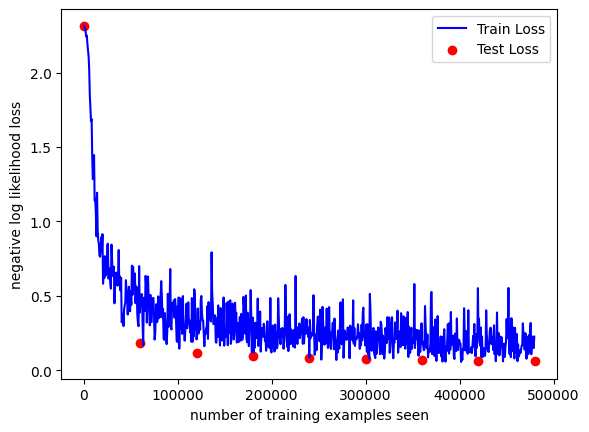

In [22]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Let's now obtain the confusion matrix for our "continued" network. 

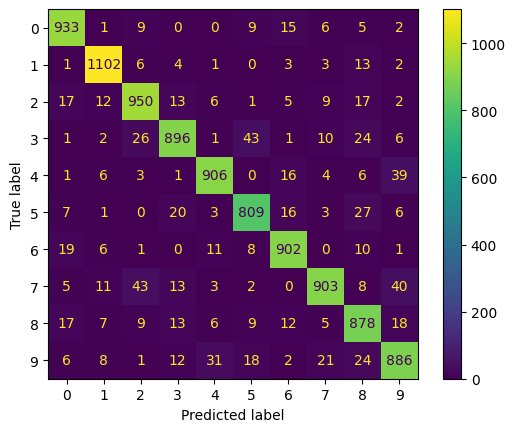

In [23]:
y_true_cont = []
y_pred_cont = []
with torch.no_grad():
  for data, target in test_loader:
    out = continued_network(data)
    pred = out.data.max(1, keepdim=True)[1]
    y_true_cont.extend(target)
    y_pred_cont.extend(pred)
cm_cont = confusion_matrix(y_true_cont, y_pred_cont)
ConfusionMatrixDisplay(cm_cont).plot()